# Find calibration coefficients to undistort fisheye camera images.

This notebook explains how to calibrate the wide angle camera on the [Donkey Car](http://donkeycar.com)

In [1]:
from base import * #convenience functions and libraries (np, pd, cv2, show_images)
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'

#library to calibrate fisheye camera with cv2 
#https://bitbucket.org/amitibo/pyfisheye
import fisheye 

Populating the interactive namespace from numpy and matplotlib


## Import calibration pictures data
For both calibration methods you need a collection of images of a checkerboard. To get this with my donkey car, I changed the camera resolution to 640x480 and my drive loop hz to 3 then started it with the drive command and pointed it at a screen that was showing the checkerboard. After moving it around in many different angles I collected ~200 images that are saved in this folder...

image size: (480, 640)


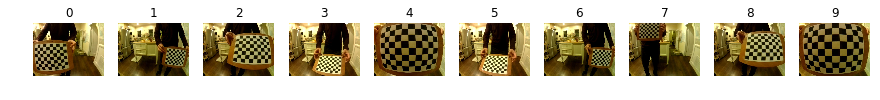

In [2]:
calib_img_folder = '/home/wroscoe/calib/good_calib/'
calib_img_list = glob.glob(os.path.join(calib_img_folder,'*.jpg'))

calib_img = plt.imread(calib_img_list[12])
show_imgs([{'name': i, 'array': plt.imread(img)} for i, img in enumerate(calib_img_list[:10])])

cb_w, cb_h =  CHECKERBOARD_SIZE = (7,9)
h, w = calib_img_size = np.array(calib_img).shape[:2]
print('image size: {}'.format(calib_img_size))

### Run calibration script

In [3]:
#this can take ~10 minutes
fe = fisheye.FishEye(nx=7, ny=9, verbose=True)
rms, K, D, rvecs, tvecs = fe.calibrate(
    calib_img_list,
    show_imgs=False
)

In [4]:
#these values are shown here as saved to avoid having to run calibration script

K = np.array([
    [ 340.56819732,    0.        ,  307.01297403],
    [   0.        ,  319.22996275,  237.70091279],
    [   0.        ,    0.        ,    1.        ]
])

D = np. array([
    [-0.02025494],
    [ 0.00573737],
    [-0.02515587],
    [ 0.01317606]
])

## Undistort

Now that we have the camera coefficients we can undistort the images.

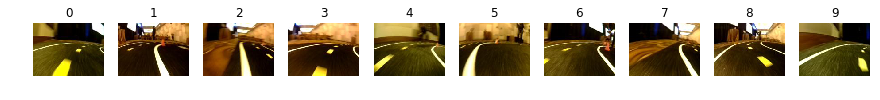

In [5]:
#load some race data.
rally_imgs_folder = '/home/wroscoe/data/rally/rally_A_02/'
rally_img_list = glob.glob(os.path.join(rally_imgs_folder,'*.jpg'))    
rally_img = plt.imread(rally_img_list[1])

show_imgs([{'name': i, 'array': plt.imread(img)} for i, img in enumerate(rally_img_list[:10])])

### Rescale the camera parameters so they work for smaller image.
I use low res (120 x 160) images on the donkey because it has a small processor but these images aren't big enough for the camera calibration to work. So we have to scale the camera calibration coefficients from 460 x 640 to 120 x 160. 

In [6]:
#Get the new ration of the new image size
x_scale = rally_img.shape[0] / calib_img.shape[0]
y_scale = rally_img.shape[1] / calib_img.shape[1]
assert x_scale == y_scale
print('scale: {}'.format(x_scale))

#scale only the top two rows.
scales = np.array([x_scale, x_scale, 1])
Kp = (K.T *  scales).T
Kp

scale: 0.25


array([[ 85.14204933,   0.        ,  76.75324351],
       [  0.        ,  79.80749069,  59.4252282 ],
       [  0.        ,   0.        ,   1.        ]])

In [7]:
def undistort(distorted_img, K, D, undistorted_size=None, R=np.eye(3)):
    """Undistort an image using the fisheye model"""

    if undistorted_size is None:
        undistorted_size = (distorted_img.shape[1], distorted_img.shape[0])

    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        K,
        D,
        R,
        K,
        undistorted_size, 
        cv2.CV_16SC2
    )

    undistorted_img = cv2.remap(
        distorted_img,
        map1,
        map2,
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )

    return undistorted_img

#### Scale the undistorted image.
We want to see as much of the image as possible.

In [8]:
R1 = np.eye(3) * np.array([1,1,1])
R15 = np.eye(3) * np.array([1,1,1.5])
R2 = np.eye(3) * np.array([1,1,2])
R4 = np.eye(3) * np.array([1,1, 4])

Rs = [R1, R15, R2, R4]

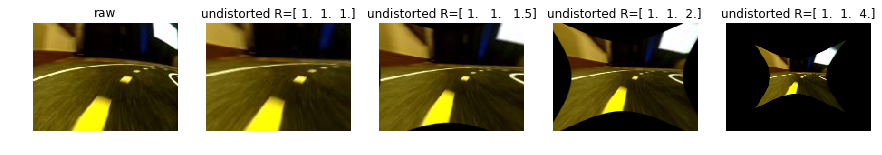

In [9]:
images_folder_path = '/home/wroscoe/data/rally/rally_A_02/'
rally_img_list = glob.glob(os.path.join(images_folder_path,'*.jpg')) 

rally_img = np.array(Image.open(rally_img_list[0]))

plot_data = [{'name': 'raw', 'array': rally_img}] 
undistort_data = [{'name': 'undistorted R={}'.format(r.sum(axis=1)), 'array': undistort(rally_img, Kp, D, R=r)} for r in Rs]
plot_data = plot_data + undistort_data
show_imgs(plot_data)

## Next Steps
Now that we can get an undistorted image we can now get a birdseye view of the track ahead. 




------------


## Gocha: Error from curved checker board? 
I got this error early on that was tough to figure out. Here's  how I fixed it. 

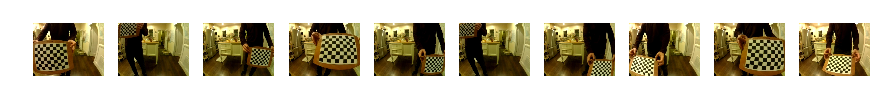

In [10]:
img_folder = '/home/wroscoe/calib/camera_calib_raw_3/'
img_list = glob.glob(os.path.join(img_folder,'*.jpg'))
show_imgs([{'array': plt.imread(img)} for img in img_list[:10]])

While these images look fine for some reason some of the images give the following error. 

In [11]:
fe = fisheye.FishEye(nx=7, ny=9, verbose=True)
rms, K, D, rvecs, tvecs = fe.calibrate(
    img_list[:10],
    show_imgs=False
)

error: /io/opencv/modules/calib3d/src/fisheye.cpp:1405: error: (-3) CALIB_CHECK_COND - Ill-conditioned matrix for input array 3 in function CalibrateExtrinsics


### The fix
The fix is to find those images that don't work and exclude them from your list of images. 

In [ ]:
good_list = []
for i, f in enumerate(calib_img_list[:10]):
    try:
        fe = fisheye.FishEye(nx=7, ny=9, verbose=True)
        rms, K, D, rvecs, tvecs = fe.calibrate(
            [calib_img_list[i]],
            show_imgs=False
        )
    except Exception:
        continue
    good_list.append(f)